Antoni Pawłowicz 191733

<div align="center">
<em>
METODY INTERAKCJI CZŁOWIEK MASZYNA</br></br>
Laboratoria 2</br>
Algorytmy estymacji i detekcji postawy ciała
</em>

In [4]:
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

### _Zadanie 1_
Używając wcześniej zdefiniowanych par połącz odpowiednie punkty liniami
tworząc szkielet obiektu.

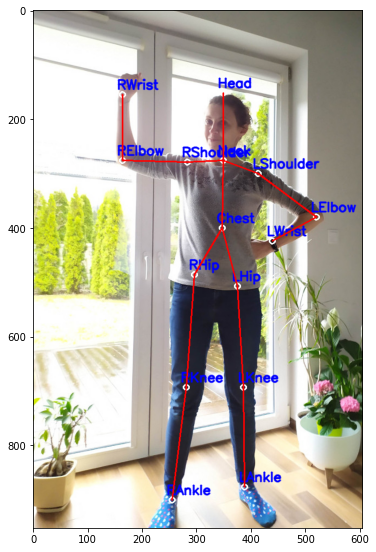

In [5]:
protoTxt = "/home/anthonyp57/VSCode_projects/MICM_2025/lab_2/OpenPose/pose_deploy_linevec_faster_4_stages.prototxt"
wagi = "/home/anthonyp57/VSCode_projects/MICM_2025/lab_2/OpenPose/pose_iter_160000.caffemodel"
cam_id = '/home/anthonyp57/VSCode_projects/MICM_2025/lab_2/6_a.jpg'

net = cv2.dnn.readNetFromCaffe(protoTxt, wagi)

img = cv2.imread(cam_id)

# here for clarity
part_to_idx = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
"LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
"RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
"Background": 15}

BODY_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder",
"RElbow"],["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder",
"LElbow"],["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"],
["RHip", "RKnee"],["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip",
"LKnee"], ["LKnee", "LAnkle"] ]

pairs_idx = [(part_to_idx[a[0]], part_to_idx[a[1]]) for a in BODY_PAIRS]
part_indices = list(part_to_idx.values())[:-1] #no backgound
part_names = list(part_to_idx.keys())[:-1]
threshold = 0.2

limb_pos = {i:None for i in part_indices}

def lines_to_limbs(image, inW=368, inH=368):
    img = copy.deepcopy(image)
    inWidth = inW
    inHeight = inH

    imW = img.shape[1]
    imH = img.shape[0]

    x_scale = imW / float(inWidth)
    y_scale = imH / float(inHeight)

    inpBlob = cv2.dnn.blobFromImage(img, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ustawienie jako input
    net.setInput(inpBlob)
    #predykcja
    output = net.forward()

    limb_map = output[0,:len(part_indices),:,:]

    for i,l in enumerate(limb_map):

        probMap = cv2.resize(l, (inWidth, inHeight))
        # zamiana skali kolorów dla confidence map i oznaczenie kolorem czerwonym
        # probMap2 = cv2.cvtColor(probMap, cv2.COLOR_GRAY2RGB) #part prob
        # probMap2[:,:,0]=0
        # probMap2[:,:,1]=0
        # img = cv2.addWeighted(img, 0.9, probMap2, 0.1, 0, dtype=cv2.CV_32F).astype(np.uint8)

        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        if prob > threshold :
            x,y = point
            y *= y_scale
            x *= x_scale
            x,y = int(x),int(y)
            cv2.circle(img, (x,y), 5, (255, 255, 255), thickness=2, lineType=cv2.FILLED)
            cv2.putText(img, f'{part_names[i]}', (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            limb_pos[i] = (x,y)
        else :
            limb_pos[i] = None

    # plt.imshow(img)

    #draw lines between connecting body parts
    for p in pairs_idx:
        if all([limb_pos[p[0]], limb_pos[p[1]]]):
            try:
                cv2.line(img, limb_pos[p[0]], limb_pos[p[1]], (255, 0, 0), 2)
            except Exception as e:
                print(f'error: {e}')

    # cv2.imshow('posenet', img)
    plt.figure(figsize=(imW/100, imH/100))
    plt.imshow(img)

lines_to_limbs(img)

### _Zadanie 2_
 Stwórz algorytm detekcji dowolnej pozy ciała na podstawie wzajemnego
położenia punktów kluczowych (ich wzajemnych odległości, kątów pomiędzy
połączeniami par itp.). Dokładnie opisz działanie algorytmu i przedstaw wyniki jego
działania.

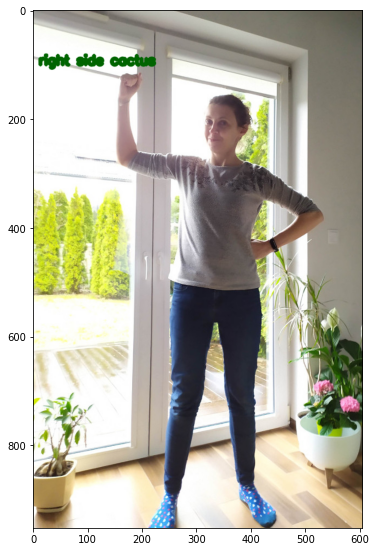

: 

In [ ]:
def calculate_angle_between_points(x, y, z):
    v1 = y - x
    v2 = z - y
    
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = np.arccos(cos_theta)
    angle = np.degrees(angle)

    return angle

def get_limb(prob):

    minVal, prob, minLoc, point = cv2.minMaxLoc(prob)

    if prob > threshold :
        x,y = point
        x,y = int(x),int(y)
    
    return x,y

def is_cactus(image, inW=368, inH=368, angle_tresh=15, dist_tresh=0.3):
    img = copy.deepcopy(image)
    inWidth = inW
    inHeight = inH

    imW = img.shape[1]
    imH = img.shape[0]

    x_scale = imW / float(inWidth)
    y_scale = imH / float(inHeight)

    inpBlob = cv2.dnn.blobFromImage(img, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ustawienie jako input
    net.setInput(inpBlob)
    #predykcja
    output = net.forward()

    limb_map = output[0,:len(part_indices),:,:]

    for i,l in enumerate(limb_map):

        probMap = cv2.resize(l, (inWidth, inHeight))

        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        if prob > threshold :
            x,y = point
            y *= y_scale
            x *= x_scale
            x,y = int(x),int(y)
            limb_pos[i] = (x,y)
        else :
            limb_pos[i] = None

    if all([limb_pos[part_to_idx[p]] for p in ['RWrist', 'LWrist', 'LElbow', 'RElbow', 'LShoulder', 'RShoulder']]):

        Neck = np.array(limb_pos[part_to_idx['Neck']])
        LShoulder = np.array(limb_pos[part_to_idx['LShoulder']])
        RShoulder = np.array(limb_pos[part_to_idx['RShoulder']])
        LElbow = np.array(limb_pos[part_to_idx['LElbow']])
        RElbow = np.array(limb_pos[part_to_idx['RElbow']])
        LWrist = np.array(limb_pos[part_to_idx['LWrist']])
        RWrist = np.array(limb_pos[part_to_idx['RWrist']])
        Head = np.array(limb_pos[part_to_idx['Head']])

        Rshoulder_elbow_dist = np.linalg.norm(Neck - RElbow)
        Lshoulder_elbow_dist = np.linalg.norm(Neck - LElbow)
        Lwrist_head_dist = np.linalg.norm(LWrist - Head)
        Rwrist_head_dist = np.linalg.norm(RWrist - Head)

        Lshoulder_elbow_wrist_angle = calculate_angle_between_points(LShoulder, LElbow, LWrist)
        Rshoulder_elbow_wrist_angle = calculate_angle_between_points(RShoulder, RElbow, RWrist)

        angles = [90-angle_tresh < Lshoulder_elbow_wrist_angle < 90+angle_tresh, 90-angle_tresh < Rshoulder_elbow_wrist_angle < 90+angle_tresh]
        dists = [Lshoulder_elbow_dist*(1-dist_tresh) < Lwrist_head_dist < Lshoulder_elbow_dist*(1+dist_tresh), Rshoulder_elbow_dist*(1-dist_tresh) < Rwrist_head_dist < Rshoulder_elbow_dist*(1+dist_tresh)]

        if any(angles) and any(dists):
            if all(angles) and all(dists):
                cv2.putText(img, 'def a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
            elif angles[0] and dists[0]:
                cv2.putText(img, 'left side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
            elif angles[1] and dists[1]:
                cv2.putText(img, 'right side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
            else:
                cv2.putText(img, 'not really a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)

    # cv2.imshow('posenet', img)
    plt.figure(figsize=(imW/100, imH/100))
    plt.imshow(img)

is_cactus(img)


#### Działanie algorytmu
##### Co chcemy osiągnąć
Chcemy sprawdzić czy osoba na zdjęciu przyjmuję pozycję "kaktusa"
##### Jak to robimy
Zczytujemy interesujące nas punkty, w tym przypadku z ogólnie pojętej górnej części ciała. Następnie liczymy kąt zgięcia w łokciach i odległości między szyja-łokieć i głowa-nadgarstek w celu sprawdzenia czy jesteśmy w pozie "kaktus" sprawdzane jest czy kąt zgięcia łokci jest bliski 90<sup>.</sup>:

```
angles = [90-angle_tresh < Lshoulder_elbow_wrist_angle < 90+angle_tresh, 90-angle_tresh < Rshoulder_elbow_wrist_angle < 90+angle_tresh]

```

A następnie czy odległość szyja-łokieć jest porównywalna do odległości głowa-nadgarstek, co z zależności motorycznych i geometrycznych oznacza że jesteśmy w praktyczniej jedynej możliwej pozycji, czyli "kaktus" albo "pół-kaktus":

```
dists = [Lshoulder_elbow_dist*(1-dist_tresh) < Lwrist_head_dist < Lshoulder_elbow_dist*(1+dist_tresh), Rshoulder_elbow_dist*(1-dist_tresh) < Rwrist_head_dist < Rshoulder_elbow_dist*(1+dist_tresh)]
```

Porównaj kąty i odległości:

```
        if any(angles) and any(dists): # sprawdź czy jest wgl jakieś podobieństwo do kaktusa

            if all(angles) and all(dists): #czy poza to "pełny kaktus"

                cv2.putText(img, 'def a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)

            elif angles[0] and dists[0]: # czy poza to jednostronny lewy kaktus
                cv2.putText(img, 'left side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)

            elif angles[1] and dists[1]: # -//- prawy kaktus
                cv2.putText(img, 'right side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
                
            else: # jak nie lewy albo prawy to wgl nie jest poza kaktusa
                cv2.putText(img, 'not really a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
```

### _Zadanie 3_
Zmień kod tak, żeby działał na obrazie z kamery (w celu przyspieszenia
działania można maksymalnie zmniejszyć klatkowanie wideo).

In [ ]:
import time

def is_cactus_camera(cam_id, inW=368, inH=368, angle_tresh=15, dist_tresh=0.3):
    cam = cv2.VideoCapture(cam_id)
    inWidth = inW
    inHeight = inH
    frame = 0
    start = time.time()

    while True:

        res, img = cam.read()
        if not res:
            raise IOError('no camera detected')
        
        imW = img.shape[1]
        imH = img.shape[0]

        x_scale = imW / float(inWidth)
        y_scale = imH / float(inHeight)

        inpBlob = cv2.dnn.blobFromImage(img, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ustawienie jako input
        net.setInput(inpBlob)
        #predykcja
        output = net.forward()

        limb_map = output[0,:len(part_indices),:,:]

        for i,l in enumerate(limb_map):

            probMap = cv2.resize(l, (inWidth, inHeight))

            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            if prob > threshold :
                x,y = point
                y *= y_scale
                x *= x_scale
                x,y = int(x),int(y)
                limb_pos[i] = (x,y)
            else :
                limb_pos[i] = None

        if all([limb_pos[part_to_idx[p]] for p in ['RWrist', 'LWrist', 'LElbow', 'RElbow', 'LShoulder', 'RShoulder']]):

            Neck = np.array(limb_pos[part_to_idx['Neck']])
            LShoulder = np.array(limb_pos[part_to_idx['LShoulder']])
            RShoulder = np.array(limb_pos[part_to_idx['RShoulder']])
            LElbow = np.array(limb_pos[part_to_idx['LElbow']])
            RElbow = np.array(limb_pos[part_to_idx['RElbow']])
            LWrist = np.array(limb_pos[part_to_idx['LWrist']])
            RWrist = np.array(limb_pos[part_to_idx['RWrist']])
            Head = np.array(limb_pos[part_to_idx['Head']])

            Rshoulder_elbow_dist = np.linalg.norm(Neck - RElbow)
            Lshoulder_elbow_dist = np.linalg.norm(Neck - LElbow)
            Lwrist_head_dist = np.linalg.norm(LWrist - Head)
            Rwrist_head_dist = np.linalg.norm(RWrist - Head)

            Lshoulder_elbow_wrist_angle = calculate_angle_between_points(LShoulder, LElbow, LWrist)
            Rshoulder_elbow_wrist_angle = calculate_angle_between_points(RShoulder, RElbow, RWrist)

            angles = [90-angle_tresh < Lshoulder_elbow_wrist_angle < 90+angle_tresh, 90-angle_tresh < Rshoulder_elbow_wrist_angle < 90+angle_tresh]
            dists = [Lshoulder_elbow_dist*(1-dist_tresh) < Lwrist_head_dist < Lshoulder_elbow_dist*(1+dist_tresh), Rshoulder_elbow_dist*(1-dist_tresh) < Rwrist_head_dist < Rshoulder_elbow_dist*(1+dist_tresh)]

            if any(angles) and any(dists):
                if all(angles) and all(dists):
                    cv2.putText(img, 'def a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
                elif angles[0] and dists[0]:
                    cv2.putText(img, 'left side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
                elif angles[1] and dists[1]:
                    cv2.putText(img, 'right side cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)
                else:
                    cv2.putText(img, 'not really a cactus', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 100, 0), 5, lineType=cv2.LINE_AA)

        cv2.imshow('posenet', img)
        # plt.figure(figsize=(imW/100, imH/100))
        # plt.imshow(img)

        frame += 1
        print(f'FPS: {frame / time.time():.2f}', end='\r')

cam_id = '/home/anthonyp57/VSCode_projects/MICM_2025/lab_3/man_vid.mp4'

is_cactus_camera(cam_id)
